In [2]:
import pandas as pd 
import numpy as np 
import sqlite3 as sql
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor

In [3]:
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

In [8]:
db = sql.connect('../data/combinedLAS_v1.db')

In [8]:
df = pd.read_sql('SELECT * FROM all_LAS', db)
df.head()

,index,BCSA_01R,BS,CAL,CLAY,COAL,DEN,DRHO,DRHO_00J,DT,...,VOL_WETCLAY,VOL_XWAT,VSAN,VSAND,VSH,VSHALE,VSHCUT,VSIL,VSTRDLAM,WELLNAME
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WELL-1
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WELL-1
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WELL-1
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WELL-1
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WELL-1


In [10]:
dfc = pd.read_sql('SELECT TVDSS,WELLNAME,GR,LLD,NEUT,DEN,DT,SWT,FLUID,KLOG,PHIT_HC FROM all_LAS \
                        WHERE GR IS NOT NULL\
                            AND LLD IS NOT NULL\
                            AND NEUT IS NOT NULL\
                            AND DEN IS NOT NULL\
                            AND TVDSS IS NOT NULL', db)
dfc.head()

,TVDSS,WELLNAME,GR,LLD,NEUT,DEN,DT,SWT,FLUID,KLOG,PHIT_HC
0,1788.9796,WELL-4,52.7022,1.7122,48.6591,2.0790,188.3938,NaN,1.0,NaN,NaN
1,1789.4796,WELL-4,54.7873,1.6778,46.4500,2.0806,189.1246,NaN,1.0,NaN,NaN
2,1789.9795,WELL-4,57.4124,1.6885,47.5805,2.0832,187.6452,NaN,1.0,NaN,NaN
3,1790.4795,WELL-4,60.8379,1.7765,47.1410,2.1145,182.0459,NaN,1.0,NaN,NaN
4,1790.9794,WELL-4,65.3761,1.8956,46.5134,2.1210,179.8477,NaN,1.0,NaN,NaN


In [37]:
dfd = pd.read_sql('SELECT TVDSS,WELLNAME,GR,LLD,NEUT,DEN,DT,SWT,FLUID,KLOG,PHIT_HC FROM selected_LAS GROUP BY WELLNAME',db)
dfd.head()

,TVDSS,WELLNAME,GR,LLD,NEUT,DEN,DT,SWT,FLUID,KLOG,PHIT_HC
0,3448.4937,WELL-10,54.3318,2.5466,0.4425,2.4836,NaN,1.0,2.0,1.1518,0.1224
1,6283.4253,WELL-11,88.1118,4.0171,26.2549,2.5498,85.8845,NaN,1.0,0.2359,0.0759
2,6651.1758,WELL-12,42.3899,7.9351,18.2022,2.5628,NaN,NaN,NaN,NaN,NaN
3,2225.4321,WELL-13,91.4684,2.6656,55.6184,1.7649,NaN,NaN,1.0,NaN,NaN
4,2222.5061,WELL-15,58.1564,1.6672,35.8441,2.3628,NaN,NaN,2.0,NaN,NaN


In [11]:
dfc.to_sql('selected_LAS', db, if_exists='replace')

In [12]:
db.close()

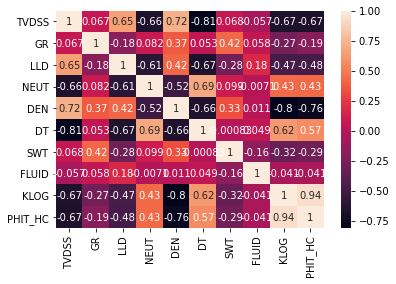

In [32]:
dfcorr = dfc.corr(method='spearman')
sn.heatmap(dfcorr, annot=True)
plt.show()

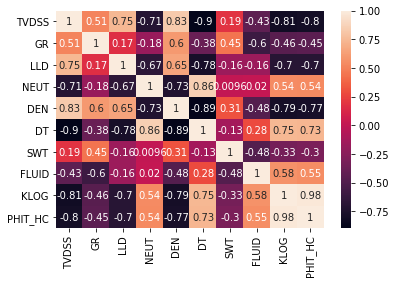

In [14]:
# Well 46
dfc46 = dfc[dfc['WELLNAME']=='WELL-46']
corr46 = dfc46.corr(method='spearman')
sn.heatmap(corr46,annot=True)
plt.show()

In [16]:
dfc46c = dfc46[dfc46.SWT.notna()]
SWT_binned = pd.cut(dfc46c.iloc[:,7],10,retbins=True,labels=range(10))
SWT_binned[0]

266921    8
266922    8
266923    8
266924    9
266925    9
         ..
272647    9
272648    9
272649    9
272650    9
272651    9
Name: SWT, Length: 5398, dtype: category
Categories (10, int64): [0 < 1 < 2 < 3 ... 6 < 7 < 8 < 9]

In [17]:
dfc46c = dfc46[dfc46.SWT.notna()]
SWT_binned = pd.cut(dfc46c.iloc[:,7],10,retbins=True,labels=range(10))
dfc46c['SWT_binned'] = SWT_binned[0]
X = dfc46c.iloc[:,[2,3,5,11]]
y = dfc46c.iloc[:,11] # Target variable

print(X.shape)
print(y.shape)

X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

(5398, 4)
(5398,)


C:\Users\imran.fadhil\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
dfc46c.head()

,TVDSS,WELLNAME,GR,LLD,NEUT,DEN,DT,SWT,FLUID,KLOG,PHIT_HC,SWT_binned
266921,1225.5570,WELL-46,74.3125,1.4979,36.5723,2.1211,167.6342,0.9108,1.0,4644.6611,0.3369,8
266922,1226.0312,WELL-46,76.3125,1.5254,37.8906,2.1133,167.0695,0.8858,1.0,5336.6714,0.3405,8
266923,1226.5055,WELL-46,75.1875,1.5593,38.4277,2.1289,165.8288,0.9061,1.0,3893.6790,0.3321,8
266924,1226.9797,WELL-46,78.0625,1.5975,41.2598,2.1406,164.1388,0.9926,1.0,2952.4392,0.3249,9
266925,1227.4540,WELL-46,80.3125,1.5861,40.5273,2.1484,164.1667,1.0000,1.0,2580.7190,0.3214,9


In [22]:
# SWT
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('MLPR', MLPRegressor(random_state=1)))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy') #cv=kfold
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

C:\Users\imran.fadhil\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


LR: 0.946041 (0.003100)
LDA: 0.940017 (0.005237)


C:\Users\imran.fadhil\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\imran.fadhil\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


KNN: 0.974988 (0.004945)
CART: 1.000000 (0.000000)
NB: 1.000000 (0.000000)


C:\Users\imran.fadhil\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\imran.fadhil\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\imran.fadhil\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


SVM: 0.984251 (0.005462)


C:\Users\imran.fadhil\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets